In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import cv2
import dlib
import json
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score

Preprocess 25 landmark 1 frame

In [ ]:
# Titik - titik landmark
LANDMARK_IDX = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
                58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
                30, 31, 33, 35, 36]  # bibir + hidung + mata

In [ ]:
# 55x55 frames dengan 5x5 landmark berarti size 55/5 = 11 (11x11 1 kotak landmark)
def extract_landmark_patch(img, x, y, size=11):
    half = size // 2
    h, w = img.shape[:2]
    x1 = max(0, x - half)
    x2 = min(w, x + half + 1)
    y1 = max(0, y - half)
    y2 = min(h, y + half + 1)

    patch = np.zeros((size, size, 3), dtype=img.dtype)
    cropped = img[y1:y2, x1:x2]
    patch[0:cropped.shape[0], 0:cropped.shape[1]] = cropped
    return patch


In [ ]:
# jadikan 5 kolom ke samping dan 5 baris ke bawah
def combine_patches_grid(patches, grid_size=5, patch_size=11):
    canvas = np.zeros((grid_size * patch_size, grid_size * patch_size, 3), dtype=np.uint8)
    for i, patch in enumerate(patches):
        row = i // grid_size
        col = i % grid_size
        canvas[row*patch_size:(row+1)*patch_size, col*patch_size:(col+1)*patch_size] = patch
    return canvas  # shape: (55, 55, 3)


In [ ]:
# Cari landmark yang akan di kotaki
def process_frame_to_landmark_grid(frame, predictor):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    shape = predictor(gray, dlib.rectangle(0, 0, gray.shape[1], gray.shape[0]))
    
    patches = []
    for idx in LANDMARK_IDX:
        x, y = shape.part(idx).x, shape.part(idx).y
        patch = extract_landmark_patch(frame, x, y)
        patches.append(patch)

    # kalau kurang lewati
    if len(patches) != 25:
        return None
    return combine_patches_grid(patches)


In [6]:
def process_face_frames_folder(input_folder, output_folder, predictor, max_frames=50):
    os.makedirs(output_folder, exist_ok=True)
    frame_files = sorted([
        f for f in os.listdir(input_folder)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])[:max_frames]

    count = 0
    for fname in frame_files:
        frame_path = os.path.join(input_folder, fname)
        frame = cv2.imread(frame_path)
        if frame is None:
            continue

        result = process_frame_to_landmark_grid(frame, predictor)
        if result is not None:
            save_path = os.path.join(output_folder, f"{count:04d}.jpg")
            cv2.imwrite(save_path, result)
            count += 1


In [7]:
def batch_process_all_face_frames(input_root, output_root, predictor):
    for video_name in sorted(os.listdir(input_root)):
        input_folder = os.path.join(input_root, video_name)
        if not os.path.isdir(input_folder):
            continue

        output_folder = os.path.join(output_root, video_name)
        process_face_frames_folder(input_folder, output_folder, predictor)
        print(f"Processed {video_name}")


In [9]:
import dlib
import cv2
import os

predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

input_root = "Dataset_Skripsi/testing CNN-BiLSTM/face_frames"              # Folder crop wajah (per video)
output_root = "Dataset_Skripsi/testing CNN-BiLSTM/landmark_55x55_frames"   # Folder output baru

batch_process_all_face_frames(input_root, output_root, predictor)

Processed aabyjxwqyo
Processed aaeflzzhvy
Processed accfrqkrni
Processed adfzvplbky
Processed adrqlckutl
Processed adsxwxeibr
Processed ahencqpiin
Processed alzbizkswy
Processed aqhbszcpal
Processed baqledjaon
Processed barbcborgl
Processed bfkzrgovsv
Processed bfljjbavig
Processed bhqcqwcise
Processed bqwwkjlmgv
Processed chjatzdqcl
Processed chnbexdyhq
Processed cmbloezomc
Processed ctsjalmkpx
Processed cuewtjauyi
Processed derkcaxbhk
Processed dnirzrdpcv
Processed dopcoxsotn
Processed dpegbdzijf
Processed dsveelyrgf
Processed dunalebmpa
Processed dvvglvssak
Processed dwmsebyypl
Processed eaxkilqqgu
Processed efqfomvqac
Processed efstpwwzpb
Processed emgciwmtuj
Processed encvnokybd
Processed enhrmlgvnt
Processed evirwnkqms
Processed evyqbkbsiv
Processed fafelguets
Processed fgtpkjnclo
Processed fpafdiehsl
Processed fqdklzzkfj
Processed gbambjdbwq
Processed ghyxplmidg
Processed gilrccufxa
Processed glxfafqbcf
Processed gnslcjmktc
Processed gvyvbdlfap
Processed hazcvdjzyf
Processed hfs

Model

In [10]:
# Depthwise Separable Convolution (DSC)
class DSCBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DSCBlock, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.relu(x)
        return x


In [11]:
# Convolutional Block Attention Module (CBAM)
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel Attention
        ca = self.channel_attention(x) * x

        # Spatial Attention
        avg_out = torch.mean(ca, dim=1, keepdim=True)
        max_out, _ = torch.max(ca, dim=1, keepdim=True)
        sa = self.spatial_attention(torch.cat([avg_out, max_out], dim=1)) * ca
        return sa

In [12]:
class CBAM_DSC_ViViT(nn.Module):
    def __init__(self, embed_dim=128, num_heads=8, num_layers=6, num_classes=2):
        super(CBAM_DSC_ViViT, self).__init__()
        self.dsc = DSCBlock(3, 64)
        self.cbam = CBAM(64) 

        self.embedding = nn.Linear(64 * 55 * 55, embed_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embed_dim, num_heads, dim_feedforward=512, dropout=0.1),
            num_layers=num_layers
        )
        self.positional_encoding = nn.Parameter(torch.zeros(1, 50, embed_dim))
        #asumsi untuk MLP Classifier (tidak disebutkan dalam paper)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):  # x: (B, T, 3, 55, 55)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        x = self.dsc(x)         # DSC
        x = self.cbam(x)        # CBAM

        x = x.reshape(B * T, -1)
        x = self.embedding(x)
        x = x.view(B, T, -1)
        
        x = x + self.positional_encoding[:, :T, :]

        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x


In [ ]:
# Model initialization
model = CBAM_DSC_ViViT()
model.eval()

CBAM_DSC_ViViT(
  (dsc): DSCBlock(
    (depthwise): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
    (pointwise): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
  )
  (cbam): CBAM(
    (channel_attention): Sequential(
      (0): AdaptiveAvgPool2d(output_size=1)
      (1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): ReLU()
      (3): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): Sigmoid()
    )
    (spatial_attention): Sequential(
      (0): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): Sigmoid()
    )
  )
  (embedding): Linear(in_features=193600, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [76]:
from torch.utils.data import Dataset
import os
import json
import cv2
import torch
import numpy as np

class VideoFramesDataset(Dataset):
    def __init__(self, frames_root_folder, metadata_path, frame_count=50):
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)

        self.video_folders = []
        for folder_name in sorted(os.listdir(frames_root_folder)):
            folder_path = os.path.join(frames_root_folder, folder_name)
            if not os.path.isdir(folder_path):
                continue
            video_name = f"{folder_name}.mp4"
            if video_name in self.metadata and self.metadata[video_name]["label"] in ["FACE-SWAP DEEPFAKE", "REAL"]:
                self.video_folders.append(folder_path)

        self.frame_count = frame_count
        self.frames_root_folder = frames_root_folder
        print(f"Total folder video yang digunakan: {len(self.video_folders)}")

    def __len__(self):
        return len(self.video_folders)

    def __getitem__(self, idx):
        folder_path = self.video_folders[idx]
        folder_name = os.path.basename(folder_path)
        video_name = f"{folder_name}.mp4"

        label_str = self.metadata.get(video_name, {}).get("label", "REAL")
        label = 1 if label_str == "FACE-SWAP DEEPFAKE" else 0

        frame_files = sorted([
            os.path.join(folder_path, f) for f in os.listdir(folder_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

        frame_files = frame_files[:self.frame_count]
        frames = []

        for fpath in frame_files:
            frame = cv2.imread(fpath)
            if frame is None:
                continue
            frame = cv2.resize(frame, (55, 55))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        while len(frames) < self.frame_count:
            frames.append(np.zeros((55, 55, 3), dtype=np.uint8))

        frames = np.array(frames).transpose(0, 3, 1, 2)
        frames = torch.tensor(frames, dtype=torch.float32) / 255.0
        return frames, torch.tensor(label, dtype=torch.long)

In [77]:
# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deepfake_model = CBAM_DSC_ViViT().to(device)
weights = torch.tensor([2.0, 1.0], device=device)  # bobot kelas REAL, DEEPFAKE
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(deepfake_model.parameters(), lr=1e-3)

In [ ]:
from torch.utils.data import random_split, DataLoader

# Load dataset and train
video_folder = "./Dataset"
metadata_path = "./Dataset/metadata.json"
dataset = VideoFramesDataset(
    frames_root_folder='Dataset/landmark_55x55_frames',
    metadata_path='Dataset/metadata.json',
    frame_count=50
)

# Hitung panjang dataset
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Bagi dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Buat dataloader untuk masing-masing subset
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

Frames shape: torch.Size([4, 50, 3, 55, 55])
Sample label: tensor([0, 0, 0, 0])


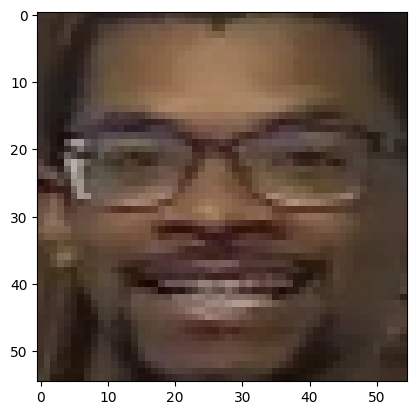

In [41]:
import matplotlib.pyplot as plt

for frames, labels in train_loader:
    print("Frames shape:", frames.shape)  # Harus (B, T, 3, 55, 55)
    print("Sample label:", labels)
    plt.imshow(frames[0][0].permute(1, 2, 0).cpu())  # Visualisasi frame pertama
    break

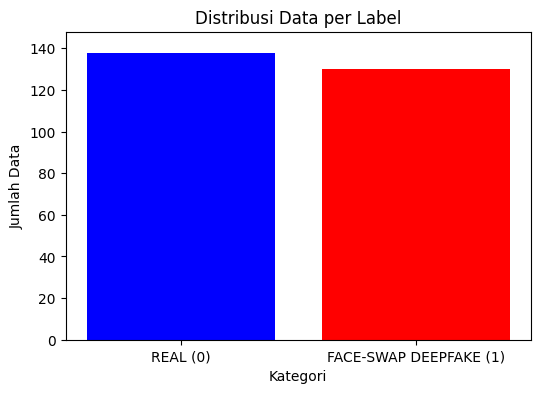

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Kumpulkan semua label dari DataLoader
all_labels = []
for _, labels in train_loader:  # Ambil hanya labelnya
    all_labels.extend(labels.numpy())  # Simpan sebagai list

# Hitung jumlah data per label
label_counts = Counter(all_labels)
labels = ["REAL (0)", "FACE-SWAP DEEPFAKE (1)"]
counts = [label_counts[0], label_counts[1]]

# Plot jumlah data per label
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=["blue", "red"])
plt.xlabel("Kategori")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Data per Label (Training)")
plt.ylim(0, max(counts) + 10)  # Tambahkan sedikit ruang di atas
plt.show()

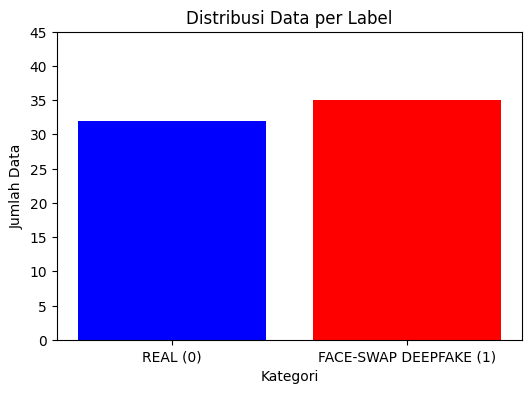

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Kumpulkan semua label dari DataLoader
all_labels = []
for _, labels in val_loader:  # Ambil hanya labelnya
    all_labels.extend(labels.numpy())  # Simpan sebagai list

# Hitung jumlah data per label
label_counts = Counter(all_labels)
labels = ["REAL (0)", "FACE-SWAP DEEPFAKE (1)"]
counts = [label_counts[0], label_counts[1]]

# Plot jumlah data per label
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=["blue", "red"])
plt.xlabel("Kategori")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Data per Label (Validation)")
plt.ylim(0, max(counts) + 10)  # Tambahkan sedikit ruang di atas
plt.show()

In [ ]:
# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 40
best_val_loss = float('inf')

# Logging
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    # === TRAINING PHASE ===
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for frames, labels in train_loader:
        frames = frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * frames.size(0)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_avg_loss = train_loss / train_total
    train_accuracy = train_correct / train_total

    # === VALIDATION PHASE ===
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = frames.to(device)
            labels = labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_avg_loss = val_loss / val_total
    val_accuracy = val_correct / val_total
    
    train_losses.append(train_avg_loss)
    val_losses.append(val_avg_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/ViViT/deepfake_ViViT_detector_3.pth')

    print(f"Epoch [{epoch}/{num_epochs}] "
            f"Train Loss: {train_avg_loss:.4f} | Train Acc: {train_accuracy:.4f} "
            f"| Val Loss: {val_avg_loss:.4f} | Val Acc: {val_accuracy:.4f}")

Epoch [1/40] Train Loss: 0.7075 | Train Acc: 0.4739 | Val Loss: 0.6522 | Val Acc: 0.5224
Epoch [2/40] Train Loss: 0.6646 | Train Acc: 0.5000 | Val Loss: 0.6639 | Val Acc: 0.5224
Epoch [3/40] Train Loss: 0.6855 | Train Acc: 0.5000 | Val Loss: 0.6515 | Val Acc: 0.5224
Epoch [4/40] Train Loss: 0.6705 | Train Acc: 0.5037 | Val Loss: 0.6522 | Val Acc: 0.5224
Epoch [5/40] Train Loss: 0.6732 | Train Acc: 0.5037 | Val Loss: 0.6541 | Val Acc: 0.5224
Epoch [6/40] Train Loss: 0.6714 | Train Acc: 0.5075 | Val Loss: 0.6525 | Val Acc: 0.5224
Epoch [7/40] Train Loss: 0.6658 | Train Acc: 0.4963 | Val Loss: 0.6763 | Val Acc: 0.5224
Epoch [8/40] Train Loss: 0.6771 | Train Acc: 0.5037 | Val Loss: 0.6579 | Val Acc: 0.5224
Epoch [9/40] Train Loss: 0.6652 | Train Acc: 0.5037 | Val Loss: 0.6530 | Val Acc: 0.5224
Epoch [10/40] Train Loss: 0.6690 | Train Acc: 0.5037 | Val Loss: 0.6520 | Val Acc: 0.5224
Epoch [11/40] Train Loss: 0.6640 | Train Acc: 0.5037 | Val Loss: 0.6541 | Val Acc: 0.5224
Epoch [12/40] Train

In [ ]:
torch.save(deepfake_model.state_dict(), "Model/ViViT/deepfake_ViViT_detector_3.pth")

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


aabyjxwqyo: Predicted = REAL, True = FACE-SWAP DEEPFAKE
aaeflzzhvy: Predicted = REAL, True = FACE-SWAP DEEPFAKE
accfrqkrni: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adfzvplbky: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adrqlckutl: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adsxwxeibr: Predicted = REAL, True = FACE-SWAP DEEPFAKE
ahencqpiin: Predicted = REAL, True = FACE-SWAP DEEPFAKE
alzbizkswy: Predicted = REAL, True = REAL
aqhbszcpal: Predicted = REAL, True = FACE-SWAP DEEPFAKE
baqledjaon: Predicted = REAL, True = FACE-SWAP DEEPFAKE
barbcborgl: Predicted = REAL, True = REAL
bfkzrgovsv: Predicted = REAL, True = REAL
bfljjbavig: Predicted = REAL, True = FACE-SWAP DEEPFAKE
bhqcqwcise: Predicted = REAL, True = REAL
bqwwkjlmgv: Predicted = REAL, True = FACE-SWAP DEEPFAKE
chjatzdqcl: Predicted = REAL, True = REAL
chnbexdyhq: Predicted = REAL, True = REAL
cmbloezomc: Predicted = REAL, True = FACE-SWAP DEEPFAKE
⚠️ ctsjalmkpx tidak ada di metadata.json
cuewtjauyi: Predicted = REAL, True 

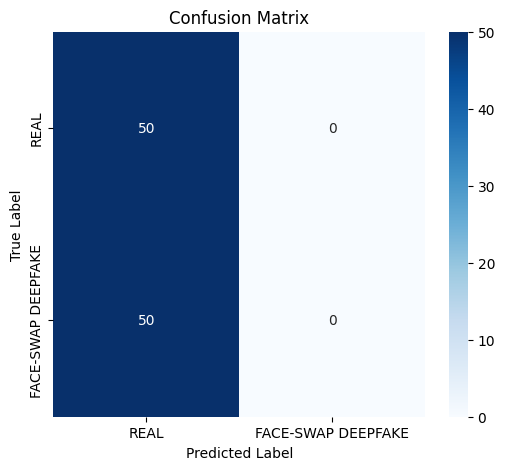


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.50      1.00      0.67        50
FACE-SWAP DEEPFAKE       0.00      0.00      0.00        50

          accuracy                           0.50       100
         macro avg       0.25      0.50      0.33       100
      weighted avg       0.25      0.50      0.33       100


📈 AUC Score: 0.5000


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

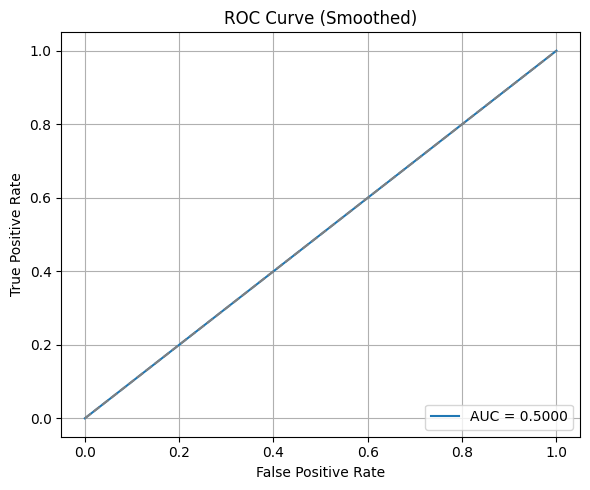

In [ ]:
import os
import json
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = CBAM_DSC_ViViT()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/ViViT/deepfake_ViViT_detector_3.pth"
frames_root = "Dataset_Skripsi/testing CNN-BiLSTM/landmark_55x55_frames"
metadata_path = "Dataset/testing/metadata.json"

# Load model dan metadata
model = load_model(model_path)
with open(metadata_path, "r") as f:
    metadata = json.load(f)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
label_map = {"REAL": 0, "FACE-SWAP DEEPFAKE": 1}

true_labels, predicted_labels, probs_class1 = [], [], []

# Loop setiap folder video
for video_name in sorted(os.listdir(frames_root)):
    video_folder = os.path.join(frames_root, video_name)
    if not os.path.isdir(video_folder):
        continue

    # Ambil label dari metadata
    if video_name+".mp4" not in metadata:
        print(f"⚠️ {video_name} tidak ada di metadata.json")
        continue

    label_str = metadata[video_name+".mp4"]["label"]
    if label_str not in label_map:
        print(f"⚠️ Label {label_str} tidak dikenali.")
        continue
    true_label = label_map[label_str]

    # Load semua frame jpg sebagai grayscale
    frame_files = sorted([
        f for f in os.listdir(video_folder)
        if f.lower().endswith('.jpg')
    ])
    frames = []
    for fname in frame_files:
        fpath = os.path.join(video_folder, fname)
        img = cv2.imread(fpath)  # default BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # ubah ke RGB

        img = img.astype(np.float32) / 255.0  # Normalisasi
        img = np.transpose(img, (2, 0, 1))    # (H, W, C) → (C, H, W)
        frames.append(torch.tensor(img))

    if len(frames) == 0:
        print(f"⚠️ {video_name} tidak memiliki frame yang valid.")
        continue

    frames = torch.stack(frames).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        outputs = model(frames)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        pred = int(np.argmax(probs))
        probs_class1.append(probs[1])

    print(f"{video_name}: Predicted = {classes[pred]}, True = {classes[true_label]}")
    true_labels.append(true_label)
    predicted_labels.append(pred)

# Evaluasi
accuracy = sum(p == t for p, t in zip(predicted_labels, true_labels)) / len(true_labels)
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")
    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
